In [1]:
import os
import sys
sys.path.append('/Users/aghavamp/Desktop/Projects')
sys.path.append('/Users/aghavamp/Desktop/Projects/bimanual_wrist')
sys.path.append('/Users/aghavamp/Desktop/Projects/Functional_Fusion')
sys.path.append('/Users/aghavamp/Desktop/Projects/AnatSearchlight')
sys.path.append('/Users/aghavamp/Desktop/Projects/SUITPy')
import getpass
import importlib
import tqdm

import scipy.io as sio
import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from pathlib import Path
import seaborn as sns
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel
import glob
import matplotlib.patches as patches
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



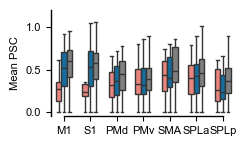

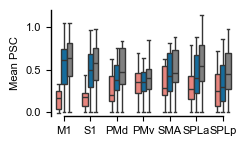

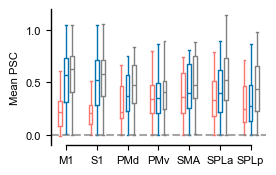

In [7]:
regions = ['SMA','PMv','PMd','M1','S1','SPLa','SPLp']
region_code = [5, 4, 3, 2, 1, 7, 8]
hem = ['L', 'R']
conditions = ['rhand','lhand','bi']
num_subj = 14

data = nb.load(os.path.join(analysisDir, 'psc.dscalar.nii'))
scalar_axis = data.header.get_axis(0)
row_names = [ax[0] for ax in scalar_axis]
idx_lhand = [i for i in range(len(row_names)) if 'lhand' in row_names[i]][0:num_subj]
idx_rhand = [i for i in range(len(row_names)) if 'rhand' in row_names[i]][0:num_subj]
idx_bi = [i for i in range(len(row_names)) if 'bi' in row_names[i]][0:num_subj]
indices = {'lhand': idx_lhand,
           'rhand': idx_rhand,
           'bi': idx_bi}
cons = data.get_fdata() 

ROI_L = nb.load('/Volumes/Diedrichsen_data$/data/Atlas_templates/fs_LR_32/ROI.32k.L.label.gii')
ROI_R = nb.load('/Volumes/Diedrichsen_data$/data/Atlas_templates/fs_LR_32/ROI.32k.R.label.gii')
ROI = {'L': ROI_L.darrays[0].data,
        'R': ROI_R.darrays[0].data}

ana = {'sn':[], 
       'region':[],
       'hem':[],
       'cond':[],
       'psc':[],
       'lateral':[]
}

for hidx, h in enumerate(hem):
    for r, roi in enumerate(regions):
        for cond in conditions:
            idx = indices[cond]
            for i in range(num_subj):
                con_sn = cons[idx[i], hidx*32492:(hidx+1)*32492] # left hem data
                region_con = con_sn[ROI[h]==region_code[r]]

                ana['psc'].append(np.nanmean(region_con))
                ana['sn'].append(i)
                ana['region'].append(roi)
                ana['cond'].append(cond)
                ana['hem'].append(h)
                if cond=='lhand' and h=='L':
                    ana['lateral'].append('ipsi')
                elif cond=='lhand' and h=='R':
                    ana['lateral'].append('contra')
                elif cond=='rhand' and h=='L':
                    ana['lateral'].append('contra')
                elif cond=='rhand' and h=='R':
                    ana['lateral'].append('ipsi')  
                else:
                    ana['lateral'].append('bi')

df = pd.DataFrame(ana)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 8

# boxplot:
fig, ax = plt.subplots(figsize=(2.5,1.5))
sns.boxplot(data=df[df.hem=='L'], x='region', y='psc', hue='lateral', ax=ax, width=0.6, palette=['#F8766D','#0072B2','#808080'], hue_order=['ipsi','contra','bi'],legend=False,
            order=['M1','S1','PMd','PMv','SMA','SPLa','SPLp'], fliersize=0)
plt.ylim((-0.05,1.2))
ax.set_yticks([0, 0.5, 1])
# plt.title(f'Left Hemisphere')
plt.ylabel('Mean PSC')
plt.xlabel('')
utils.please.make_it_pretty(ax=ax)
plt.tight_layout()

plt.savefig(f'../figures/PSC/average_PSC_leftHemisphere.pdf', bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(figsize=(2.5,1.5))
sns.boxplot(data=df[df.hem=='R'], x='region', y='psc', hue='lateral', ax=ax, width=0.6, palette=['#F8766D','#0072B2','#808080'],  hue_order=['ipsi','contra','bi'], legend=False,
            order=['M1','S1','PMd','PMv','SMA','SPLa','SPLp'], fliersize=0)
plt.ylim((-0.05,1.2))
ax.set_yticks([0, 0.5, 1])
# plt.title(f'Right Hemisphere')
plt.ylabel('Mean PSC')
plt.xlabel('')
utils.please.make_it_pretty(ax=ax)
plt.tight_layout()
plt.savefig(f'../figures/PSC/average_PSC_rightHemisphere.pdf', bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(figsize=(2.8,1.8))
sns.boxplot(data=df, x='region', y='psc', hue='lateral', ax=ax, width=0.6, palette=['#F8766D','#0072B2','#808080'],  hue_order=['ipsi','contra','bi'], legend=False,
            order=['M1','S1','PMd','PMv','SMA','SPLa','SPLp'], fliersize=0, linewidth=1, gap=0.4, fill=False)
ax.axhline(0, color='grey', linestyle='--', linewidth=1.5, alpha=0.7)
plt.ylim((-0.1,1.2))
ax.set_yticks([0, 0.5, 1])
# plt.title(f'Right Hemisphere')
plt.ylabel('Mean PSC')
plt.xlabel('')
utils.please.make_it_pretty(ax=ax)
plt.tight_layout()
plt.savefig(f'../figures/PSC/average_PSC.pdf', bbox_inches="tight")
plt.show()



## stats within ROI:

In [35]:
from statsmodels.stats.anova import AnovaRM
# Multiple-comparisons corrections
from statsmodels.stats.multitest import multipletests
# Post-hoc paired t-tests for all condition pairs
from itertools import combinations
from scipy import stats

regions = ['SMA','PMv','PMd','M1','S1','SPLa','SPLp']
lateral = ['ipsi','contra','bi']

for hem in ['L','R']:
    for region in regions:
        df_tmp = df[(df.region==region) & (df.hem==hem)]
        # Repeated-measures ANOVA
        anova = AnovaRM(df_tmp, depvar='psc', subject='sn', within=['lateral']).fit()
        print(f'\n\n==================== {region}_{hem} ====================')
        print(anova)

        pairs = list(combinations(lateral, 2))
        wide = df_tmp.pivot(index='sn', columns='lateral', values='psc')  # subject x condition
        results = []
        for a,b in pairs:
            t, p = stats.ttest_rel(wide[a], wide[b])  # paired t-test
            results.append({'A': a, 'B': b, 't': t, 'p_unc': p})

        res_df = pd.DataFrame(results)

        # Holm-Bonferroni (FWER control)
        rejected_holm, p_holm, _, _ = multipletests(res_df['p_unc'].values, alpha=0.05, method='holm')
        res_df['p_holm'] = p_holm
        res_df['sig_holm'] = rejected_holm

        # Benjamini–Hochberg FDR (q=0.05)
        rejected_fdr, p_fdr, _, _ = multipletests(res_df['p_unc'].values, alpha=0.05, method='fdr_bh')
        res_df['p_fdr'] = p_fdr
        res_df['sig_fdr'] = rejected_fdr

        print("Post-hoc paired t-tests with Holm and FDR:")
        print(res_df)





==================== SMA_L ====================
                Anova
        F Value Num DF  Den DF Pr > F
-------------------------------------
lateral 25.7880 2.0000 26.0000 0.0000

Post-hoc paired t-tests with Holm and FDR:
        A       B         t     p_unc    p_holm  sig_holm     p_fdr  sig_fdr
0    ipsi  contra -1.284627  0.221342  0.221342     False  0.221342    False
1    ipsi      bi -6.197980  0.000032  0.000065      True  0.000048     True
2  contra      bi -6.513159  0.000020  0.000059      True  0.000048     True


==================== PMv_L ====================
                Anova
        F Value Num DF  Den DF Pr > F
-------------------------------------
lateral  7.8458 2.0000 26.0000 0.0022

Post-hoc paired t-tests with Holm and FDR:
        A       B         t     p_unc    p_holm  sig_holm     p_fdr  sig_fdr
0    ipsi  contra -0.255971  0.801979  0.801979     False  0.801979    False
1    ipsi      bi -3.440452  0.004388  0.008776      True  0.006582     True
2